<a href="https://colab.research.google.com/github/acharjee19/Machine-learning-and-data-science/blob/master/R_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install matplotlib




In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mr2CumYzyet8O77mLhnz")
project = rf.workspace("strawberry-disease").project("strawberry-disease-detection-dataset")
version = project.version(4)
dataset = version.download("coco")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Strawberry-Disease-Detection-Dataset-4 in coco:: 100%|██████████| 4906/4906 [00:00<00:00, 6961.79it/s]


In [ ]:
##  Visualizing Dataset Using ImageDataGenerator

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
# Install the required libraries
!pip install torch torchvision roboflow


In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(dataset.location)


/content/Strawberry-Disease-Detection-Dataset-4


In [ ]:
dataset_path = dataset.location  # The dataset path from Roboflow download
images_dir = os.path.join(dataset_path, 'train')  # Adjust if needed based on your dataset folder structure



In [ ]:
images_dir

'/content/Strawberry-Disease-Detection-Dataset-4/train'

In [ ]:
images_dir = os.path.join(dataset.location, 'train', 'class_name')  # Replace 'class_name' with actual class folder name


In [ ]:
print(len(images_dir))

64


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Set the path to the training images
images_dir = '/content/Strawberry-Disease-Detection-Dataset-4'  # Adjust the path as necessary

# List the image files
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Display the first 5 images (or as many as available)
for i in range(min(5, len(image_files))):  # Use min to avoid out-of-range errors
    img = cv2.imread(image_files[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.show()


In [ ]:
images_dir

'/content/Strawberry-Disease-Detection-Dataset-4'

In [ ]:
import os

# Set the path to your dataset directory
train_dir = '/content/Strawberry-Disease-Detection-Dataset-4/train'
test_dir = '/content/Strawberry-Disease-Detection-Dataset-4/test'

# Get the list of classes from the train directory
classes = os.listdir(train_dir)

# Count the number of classes (labels)
num_classes = len(classes)

print(f"Number of classes in the training dataset: {num_classes}")
print(f"Classes: {classes}")


Number of classes in the training dataset: 3427
Classes: ['powdery_mildew_fruit134_jpg.rf.a11ea7356de052967c33e0a027f4bbf8.jpg', 'angular_leafspot20_jpg.rf.2ef9f87c33a7b495cb771dbc36437b3a.jpg', 'gray_mold95_jpg.rf.aa24d12da05cdd5c57e6b548e8c908c8.jpg', 'gray_mold80.rf.05c39c3bdaaf62346ea5fa291d1e477f.jpg', 'angular_leafspot234_jpg.rf.9e870bab21f7d5a5e3da6b3995a697d7.jpg', 'gray_mold85_jpg.rf.65ccbc8d264c82c783a06a22ea612de4.jpg', 'powdery_mildew_leaf516.rf.b9a655deeb49a483166fc1c3f118c8f7.jpg', 'leaf_spot550.rf.2c70f4bebe16d922159cd2525dd3f2ee.jpg', 'gray_mold221.rf.ced658802f3ad4d72dee8bfc66ee05a0.jpg', 'leaf_spot255.rf.0e4ddc0cbb5e38b642a93e4ecfe0b6aa.jpg', 'leaf_spot482_jpg.rf.6f6694c0611a6c80528f0cdb409388b7.jpg', 'angular_leafspot415_jpg.rf.1f7ef943800d8d357a01b57f9177ea3c.jpg', 'angular_leafspot36_jpg.rf.514d401bfda2989bfe34d5f9333d5642.jpg', 'powdery_mildew_leaf239.rf.1bb1ee2cbd351c461f5a66ae4033a35b.jpg', 'leaf_spot434_jpg.rf.140b93f349f9e4f1bbe117800e3f686c.jpg', 'gray_mold26

In [ ]:
import os
import glob

# Define the path to the labels directory
labels_dir = '/content/Strawberry-Disease-Detection-Dataset-4/train/labels'

# Collect all label files
label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

# Create a set to store unique class labels
labels_set = set()

# Loop through each label file and extract class IDs
for label_file in label_files:
    with open(label_file, 'r') as f:
        for line in f.readlines():
            label_id = line.split()[0]  # Assuming the first value is the class label ID
            labels_set.add(label_id)

# Show the unique labels found
labels_set


set()

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the directory containing training images
train_images_dir = "/content/Strawberry-Disease-Detection-Dataset-4/train/images"

# List all image files in the directory
image_files = os.listdir(train_images_dir)

# Check if there are any images in the directory
if image_files:
    # Select the first image to display
    img_path = os.path.join(train_images_dir, image_files[0])

    # Load the image using OpenCV
    img = cv2.imread(img_path)

    if img is not None:
        # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.imshow(img_rgb)
        plt.title(f"Image: {image_files[0]}")
        plt.axis('off')  # Hide axis
        plt.show()
    else:
        print(f"Error loading image: {img_path}")
else:
    print("No images found in the training directory.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/Strawberry-Disease-Detection-Dataset-4/train/images'

In [ ]:
##################################3

In [ ]:
image_dir = "/content/Strawberry-Disease-Detection-Dataset-4/train"
annotation_file = "/content/Strawberry-Disease-Detection-Dataset-4/train/_annotations.coco.json"



In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
dataset_path = "/content/Strawberry-Disease-Detection-Dataset-4"

In [ ]:
class StrawberryDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


{0: {'id': 0, 'name': 'Strawberry-Disease', 'supercategory': 'none'},
 1: {'id': 1,
  'name': 'Angular Leafspot',
  'supercategory': 'Strawberry-Disease'},
 2: {'id': 2,
  'name': 'Anthracnose Fruit Rot',
  'supercategory': 'Strawberry-Disease'},
 3: {'id': 3, 'name': 'Blossom Blight', 'supercategory': 'Strawberry-Disease'},
 4: {'id': 4, 'name': 'Gray Mold', 'supercategory': 'Strawberry-Disease'},
 5: {'id': 5, 'name': 'Leaf Spot', 'supercategory': 'Strawberry-Disease'},
 6: {'id': 6,
  'name': 'Powdery Mildew Fruit',
  'supercategory': 'Strawberry-Disease'},
 7: {'id': 7,
  'name': 'Powdery Mildew Leaf',
  'supercategory': 'Strawberry-Disease'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Strawberry-Disease',
 'Angular Leafspot',
 'Anthracnose Fruit Rot',
 'Blossom Blight',
 'Gray Mold',
 'Leaf Spot',
 'Powdery Mildew Fruit',
 'Powdery Mildew Leaf']

In [ ]:
train_dataset = StrawberryDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


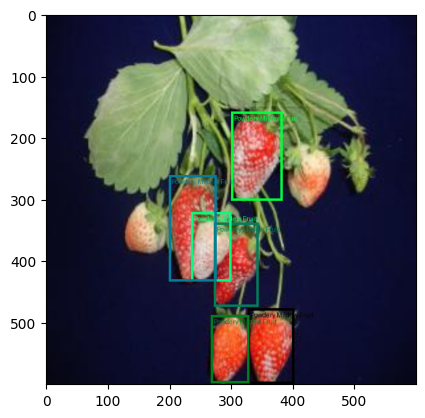

In [ ]:
# Lets view a sample
sample = train_dataset[155]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

3426

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 144MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:

device = torch.device("cpu")
model = model.to(device)


In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

## Training

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

 67%|██████▋   | 578/857 [1:22:45<37:43,  8.11s/it]

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = StrawberryDetection(root=dataset_path, split="test", transforms=get_transforms(False))

In [ ]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*224, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
### Evalution

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define transformations (customize as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),  # Adjust based on model input size
])

# Create datasets for train, validation, and test
train_dataset = ImageFolder(root='/content/Strawberry-Disease-Detection-Dataset-4/train', transform=transform)
valid_dataset = ImageFolder(root='/content/Strawberry-Disease-Detection-Dataset-4/valid', transform=transform)
test_dataset = ImageFolder(root='/content/Strawberry-Disease-Detection-Dataset-4/test', transform=transform)

# DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
import torch
from torchvision.ops import box_iou
import numpy as np

# Set model to evaluation mode
model.eval()

# Define a function to evaluate IoU across the validation set
def evaluate_model_iou(val_loader, model, device):
    iou_scores = []

    with torch.no_grad():
        for images, targets in val_loader:
            # Move images and targets to the appropriate device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            predictions = model(images)

            # Calculate IoU for each image in the batch
            for i in range(len(predictions)):
                # Predicted and ground truth boxes
                pred_boxes = predictions[i]['boxes'].cpu()
                gt_boxes = targets[i]['boxes'].cpu()

                # Calculate IoU and take the mean over pairs
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    iou = box_iou(pred_boxes, gt_boxes)
                    mean_iou = iou.mean().item()  # Mean IoU for this image
                    iou_scores.append(mean_iou)
                else:
                    # If there are no boxes, set IoU to 0
                    iou_scores.append(0.0)

    # Calculate and print average IoU over the dataset
    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    print(f'Average IoU over the validation set: {avg_iou:.4f}')
    return avg_iou

# Call the evaluation function
average_iou = evaluate_model_iou(val_loader, model, device)
